# Test reduced variance of gene expression data

**Motivation**: When we plotted a volcano plot of the E-GEOD-51409 array experiment using the [actual data](volcano_original_data_E-GEOD-51409_example_adjp.png) and the [experiment-level simulated data](volcano_simulated_data_E-GEOD-51409_example_adjp.png), we found that the simulated data had reduced variance based on the squished log fold chance values.

**Question:** What is causing the reduced variance in the simulated data? Is this reduced variance 1) a property of the variational autoencoder (VAE) algorithm or 2) the result of the latent space shifting (see [simulate_compendium module](../functions/generate_data_parallel.py)?

**Approach:**
This notebook aims to answer this question by performing 3 short experiments, each building off of the next. 
1. In the first experiment, we test the effect of applying the VAE. 
2. In the second experiment, we test the effect of sampling from the VAE latent space to simulate gene expression data (i.e. [sample-level-simulation](../Pseudomonas/Pseudomonas_sample_lvl_sim.ipynb) approach). 
3. In the third experiment, we test the effect of the latent space shifting (i.e. [experiment-level simulation](../Pseudomonas/Pseudomonas_experiment_lvl_sim.ipynb) approach).

**Conclusion:** The VAE is minimally contributes the the reduced variance. Most of the reduced variance is due to the sampling of the latent space due to the Normal constraint of the latent space.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import sys
import glob
import pandas as pd
import numpy as np
import random
from keras.models import load_model

sys.path.append("../")
from ponyo import utils

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from numpy.random import seed
randomState = 123
seed(randomState)

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# Read in config variables
# Pick one of the Pseudomonas config files
# Doesn't matter if sample or experiment level for this notebook
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs", 
                                           "config_Pa_sample_limma.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']

## Experiment 1
### Testing the effect of the VAE

In this experiment we want to test the effect of the VAE on the gene expression variance. 

To do this we will compare the distribution of the gene variance in the [original dataset](../Pseudomonas/data/input/train_set_normalized.pcl), which does not use the VAE, versus the original data after it has been encoded and decoded by the VAE. The only variable we are varying is the application of the VAE.

In [4]:
# Load datasets from the actual data and the simulate data
no_vae_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "data",
    "input",
    "train_set_normalized.pcl")

# Load VAE encoder and decoder models
NN_dir = os.path.join(
    base_dir, 
    dataset_name,
    "models",
    NN_architecture)
model_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "*_decoder_weights.h5"))[0]

loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

/home/alexandra/anaconda3/envs/simulate_expression_compendia/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# Read in datasets
no_vae_data = pd.read_table(
    no_vae_file,
    header=0,
    index_col=0,
    sep='\t').T

print(no_vae_data.shape)
no_vae_data.head()

(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


In [6]:
# Pass original data through VAE
# Encode selected experiment into latent space
data_encoded = loaded_model.predict_on_batch(no_vae_data)
data_encoded_df = pd.DataFrame(
    data_encoded, 
    index=no_vae_data.index)

# Decode simulated data into raw gene space
data_decoded = loaded_decode_model.predict_on_batch(data_encoded_df)

vae_data = pd.DataFrame(data_decoded,
                        index=data_encoded_df.index,
                        columns=no_vae_data.columns)

print(vae_data.shape)
vae_data.head()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.894237,0.780946,0.731472,0.796856,0.668379,0.531604,0.157061,0.845736,0.896036,0.202803,...,0.554378,0.697571,0.826805,0.900660,0.884241,0.181237,0.830681,0.885766,0.891832,0.877165
54375-4-05.CEL,0.803662,0.734466,0.621676,0.817192,0.439155,0.502060,0.150218,0.748432,0.770522,0.244757,...,0.337211,0.705978,0.733791,0.714026,0.691061,0.160216,0.594697,0.763777,0.750924,0.775861
AKGlu_plus_nt_7-8-09_s1.CEL,0.806109,0.742191,0.686317,0.708182,0.582554,0.530915,0.139200,0.723767,0.799073,0.222983,...,0.439625,0.707537,0.780318,0.835113,0.858853,0.139356,0.767162,0.779176,0.855484,0.850771
anaerobic_NO3_1.CEL,0.604500,0.564929,0.363628,0.352054,0.320401,0.331398,0.532046,0.320948,0.304054,0.161465,...,0.324783,0.492627,0.577030,0.484174,0.676662,0.243639,0.557044,0.232802,0.452041,0.512898
anaerobic_NO3_2.CEL,0.620761,0.568240,0.376704,0.359176,0.328371,0.330504,0.529502,0.321595,0.307615,0.159862,...,0.331766,0.505574,0.589016,0.497550,0.688157,0.233547,0.554637,0.240336,0.460281,0.524680


In [7]:
# Get variance per gene
var_no_vae = no_vae_data.var(axis=0)
var_vae= vae_data.var(axis=0)

In [8]:
df_vae = pd.DataFrame(list(zip(var_no_vae, var_vae)), 
               columns =['original', 'original after VAE']) 
df_vae.head()

,original,original after VAE
0,0.038100,0.035405
1,0.028091,0.025848
2,0.019520,0.016982
3,0.034320,0.030342
4,0.026013,0.020894


In [9]:
# Plot distribution of variances using original data and original data passed through the VAE
boxplot = df_vae.boxplot(column=['original', 'original after VAE'])
_ = boxplot.set_title("Distribution of per-gene expression variances")
_ = boxplot.set_ylabel("variances per gene")

**Observations:** The VAE model (encoder + decoder) does not appear to have much of an effect on the variance. This is expected, given that the model was trained to reconstruct the input data

## Experiment 2
### Testing the effect of sampling from the latent space to simulate data

In this experiment we want to test the effect of sampling from the VAE latent space on the gene expression variance. 

To do this we will compare the distribution of the gene variance in the [original dataset](../Pseudomonas/data/input/train_set_normalized.pcl) versus a simulated dataset generated using the [sample-level simulation](../Pseudomonas/Pseudomonas_sample_lvl_sim.ipynb), which uses the learned latent space of the VAE to simulate new data. Building off of the results from experiment 1, we add sampling from the latent space as a factor in this experiment.

In [10]:
# Load datasets from the actual data and the sample-simulated data
no_sampling_file = os.path.join(
    base_dir,
    "Pseudomonas",
    "data",
    "input",
    "train_set_normalized.pcl")

vae_sampling_file = os.path.join(
    local_dir,
    "experiment_simulated",
    "Pseudomonas_sample_lvl_sim",
    "Experiment_1_0.txt.xz")

In [11]:
# Read in datasets
no_sampling_data = pd.read_table(
    no_sampling_file,
    header=0,
    index_col=0,
    sep='\t').T

vae_sampling_data = pd.read_table(
    vae_sampling_file,
    header=0,
    index_col=0,
    sep='\t')

print(no_sampling_data.shape)
no_sampling_data.head()

(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


In [12]:
print(vae_sampling_data.shape)
vae_sampling_data.head()

(6000, 5549)


,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.524893,0.520740,0.437727,0.503881,0.381821,0.447112,0.322690,0.448206,0.418196,0.214085,...,0.452529,0.469783,0.541290,0.466450,0.490254,0.386582,0.461289,0.511527,0.703659,0.681971
1,0.637191,0.642319,0.469714,0.620168,0.410521,0.380123,0.317894,0.591224,0.540865,0.178979,...,0.375130,0.558720,0.566576,0.531656,0.597858,0.236743,0.505707,0.538541,0.672413,0.678159
2,0.579925,0.589930,0.416886,0.573579,0.343545,0.375572,0.451579,0.498441,0.447957,0.211432,...,0.375602,0.555890,0.480001,0.472683,0.514420,0.279362,0.499572,0.444599,0.525686,0.503861
3,0.577142,0.594846,0.424863,0.555629,0.377089,0.432764,0.404817,0.489170,0.426781,0.202450,...,0.388163,0.525106,0.514754,0.489396,0.526913,0.257425,0.458029,0.440186,0.618535,0.605404
4,0.564590,0.610596,0.393297,0.505810,0.393261,0.374961,0.289844,0.525382,0.483766,0.237359,...,0.349643,0.567037,0.546622,0.510529,0.569359,0.212567,0.565946,0.432346,0.704998,0.729451


In [13]:
# Get variance per gene
var_no_sampling = no_sampling_data.var(axis=0)
var_vae_sampling= vae_sampling_data.var(axis=0)

In [14]:
df_sampling = pd.DataFrame(list(zip(var_no_sampling, var_vae_sampling)), 
               columns =['original', 'sample simulated']) 
df_sampling.head()

,original,sample simulated
0,0.038100,0.006284
1,0.028091,0.003596
2,0.019520,0.003598
3,0.034320,0.005539
4,0.026013,0.003882


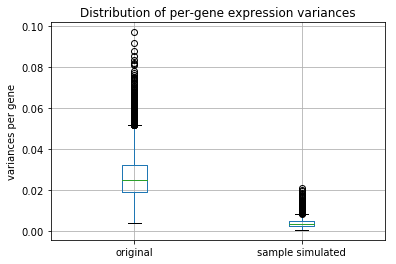

In [15]:
# Plot distribution of variances using original and sample-simulated data
boxplot = df_sampling.boxplot(column=['original', 'sample simulated'])
_ = boxplot.set_title("Distribution of per-gene expression variances")
_ = boxplot.set_ylabel("variances per gene")

**Observations**:
Based on the results it looks like there is some shrinkage of the variance using the VAE latent space to sample from. This is expected given the assumption that the VAE is making for latent space features to draw from a standard Normal distribution. Without this constraint, there are sparse regions in the latent space (i.e. the space is not continuous) that make generating relalistic 
data from these regions difficult because there is no information about this space. Therefore, this constraint was added ontop of the generic autoencoder (AE) in order to reduce the variance in the latent space to ensure a continuous latent space. Thus we would expect the VAE to squish the variance of the original data.


Some references:
- https://arxiv.org/abs/1312.6114
- https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

## Experiment 3
### Testing the effect of the latent space shift to simulate data

In this experiment we want to test the effect of the linear shift in the latent space on the gene expression variance. 

To do this we will compare the distribution of the gene variance in the simulated dataset generated using the [sample-level simulation](../Pseudomonas/Pseudomonas_sample_lvl_sim.ipynb), which does *not* perform a linear shift, versus the simulated dataset generated using the [experiment-level simulation](../Pseudomonas/Pseudomonas_experiment_lvl_sim.ipynb), which does perform a linear shift. Both simulations use the VAE, so this factor is held constant and the variable we are testing is the latent space shift.


In [16]:
# Load datasets created from the two different simulations
no_shift_file = os.path.join(
    local_dir,
    "experiment_simulated",
    "Pseudomonas_sample_lvl_sim",
    "Experiment_1_0.txt.xz")

shift_file = os.path.join(
    local_dir,
    "partition_simulated",
    "Pseudomonas_experiment_lvl_sim",
    "Partition_1_0.txt.xz")

In [17]:
# Read in datasets
no_shift_data = pd.read_table(
    no_shift_file,
    header=0,
    index_col=0,
    sep='\t')

shift_data = pd.read_table(
    shift_file,
    header=0,
    index_col=0,
    sep='\t')

print(no_shift_data.shape)
no_shift_data.head()

(6000, 5549)


,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.524893,0.520740,0.437727,0.503881,0.381821,0.447112,0.322690,0.448206,0.418196,0.214085,...,0.452529,0.469783,0.541290,0.466450,0.490254,0.386582,0.461289,0.511527,0.703659,0.681971
1,0.637191,0.642319,0.469714,0.620168,0.410521,0.380123,0.317894,0.591224,0.540865,0.178979,...,0.375130,0.558720,0.566576,0.531656,0.597858,0.236743,0.505707,0.538541,0.672413,0.678159
2,0.579925,0.589930,0.416886,0.573579,0.343545,0.375572,0.451579,0.498441,0.447957,0.211432,...,0.375602,0.555890,0.480001,0.472683,0.514420,0.279362,0.499572,0.444599,0.525686,0.503861
3,0.577142,0.594846,0.424863,0.555629,0.377089,0.432764,0.404817,0.489170,0.426781,0.202450,...,0.388163,0.525106,0.514754,0.489396,0.526913,0.257425,0.458029,0.440186,0.618535,0.605404
4,0.564590,0.610596,0.393297,0.505810,0.393261,0.374961,0.289844,0.525382,0.483766,0.237359,...,0.349643,0.567037,0.546622,0.510529,0.569359,0.212567,0.565946,0.432346,0.704998,0.729451


In [18]:
print(shift_data.shape)
shift_data.head()

(5614, 5549)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.634455,0.625769,0.503150,0.674790,0.382556,0.516121,0.526702,0.462050,0.387196,0.312756,...,0.445861,0.555707,0.637891,0.435771,0.534148,0.229338,0.271221,0.404903,0.612096,0.702427
1,0.627358,0.627293,0.503486,0.683220,0.385825,0.530789,0.518780,0.440679,0.376925,0.308939,...,0.463916,0.561225,0.635780,0.443964,0.531261,0.240135,0.291886,0.421289,0.606031,0.689835
2,0.607895,0.611168,0.500100,0.678058,0.399754,0.536595,0.496203,0.418799,0.374722,0.321040,...,0.447529,0.562199,0.629054,0.429816,0.482418,0.253325,0.274026,0.431030,0.595983,0.674272
3,0.592802,0.608616,0.497515,0.670645,0.387558,0.561180,0.531733,0.386082,0.365965,0.326617,...,0.483379,0.545276,0.604272,0.434330,0.477991,0.255534,0.281843,0.444738,0.588230,0.668904
4,0.733307,0.769780,0.388229,0.713862,0.583696,0.464944,0.850785,0.538054,0.583613,0.161236,...,0.319624,0.585686,0.527095,0.626989,0.713613,0.101546,0.355004,0.532085,0.714445,0.669498


In [19]:
# Get variance per gene
var_no_shift = no_shift_data.var(axis=0)
var_shift = shift_data.var(axis=0)

In [20]:
df_shift = pd.DataFrame(list(zip(var_no_shift, var_shift)), 
               columns =['sample simulated(not shifted)', 'experiment simulated (shifted)']) 
df_shift.head()

,sample simulated(not shifted),experiment simulated (shifted)
0,0.006284,0.017545
1,0.003596,0.016746
2,0.003598,0.022712
3,0.005539,0.016824
4,0.003882,0.014782


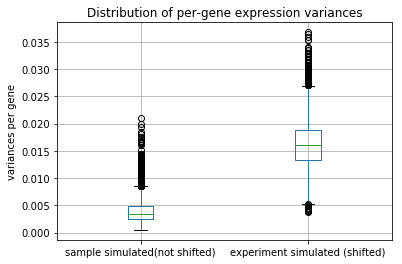

In [21]:
# Plot distribution of variances using no shifted data and shifted data
boxplot = df_shift.boxplot(column=['sample simulated(not shifted)', 
                                   'experiment simulated (shifted)'])
_ = boxplot.set_title("Distribution of per-gene expression variances")
_ = boxplot.set_ylabel("variances per gene")

**Observations:** We can see that compared to the not shifted compendium, the shifted compendium has a slightly larger variance. This makes sense given that we are shifting our samples in the latent space. The samples were shifted randomly to a new location in the latent space. Theoretically, we could get a smaller variance using the shifted approach *if* all the shifts happen to compress the samples together, however the likelihood of this happening is very rare.

## Summary

Plotting the distribution of variances per-gene for all cases (original data, sampling from VAE space, sampling and shifting in VAE space), we can see that the largest reduction in variance is due to the sampling of the VAE space.

In [22]:
df_shift = pd.DataFrame(list(zip(var_no_shift, var_shift, var_no_sampling)), 
               columns =['sample simulated(not shifted)', 'experiment simulated (shifted)', 'original']) 
df_shift.head()

,sample simulated(not shifted),experiment simulated (shifted),original
0,0.006284,0.017545,0.038100
1,0.003596,0.016746,0.028091
2,0.003598,0.022712,0.019520
3,0.005539,0.016824,0.034320
4,0.003882,0.014782,0.026013


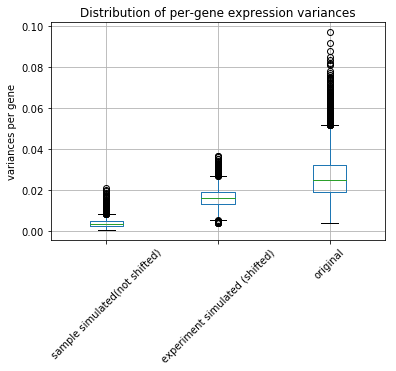

In [23]:
# Plot distribution of variances using no shifted data and shifted data
boxplot = df_shift.boxplot(column=['sample simulated(not shifted)', 
                                   'experiment simulated (shifted)', 
                                   'original'],
                          rot=45)
_ = boxplot.set_title("Distribution of per-gene expression variances")
_ = boxplot.set_ylabel("variances per gene")